In [ ]:
# 1. Cargar librerías
# Asegúrate de haberlas instalado primero con install.packages()
library(readr)
library(glmnet)
library(dplyr)
library(ggplot2)

In [2]:
# 2. Cargar y limpiar los datos
# Se asume que el archivo CSV está en tu directorio de trabajo
data <- read.csv("Districtwise_literacy_rates.csv", sep = ";")

# Tarea 1: Mantener solo observaciones sin valores faltantes (0.25 puntos)
data <- na.omit(data)
print(paste("Dimensiones del dataset sin NAs:", dim(data)[1], "filas,", dim(data)[2], "columnas"))



[1] "Dimensiones del dataset sin NAs: 625 filas, 100 columnas"


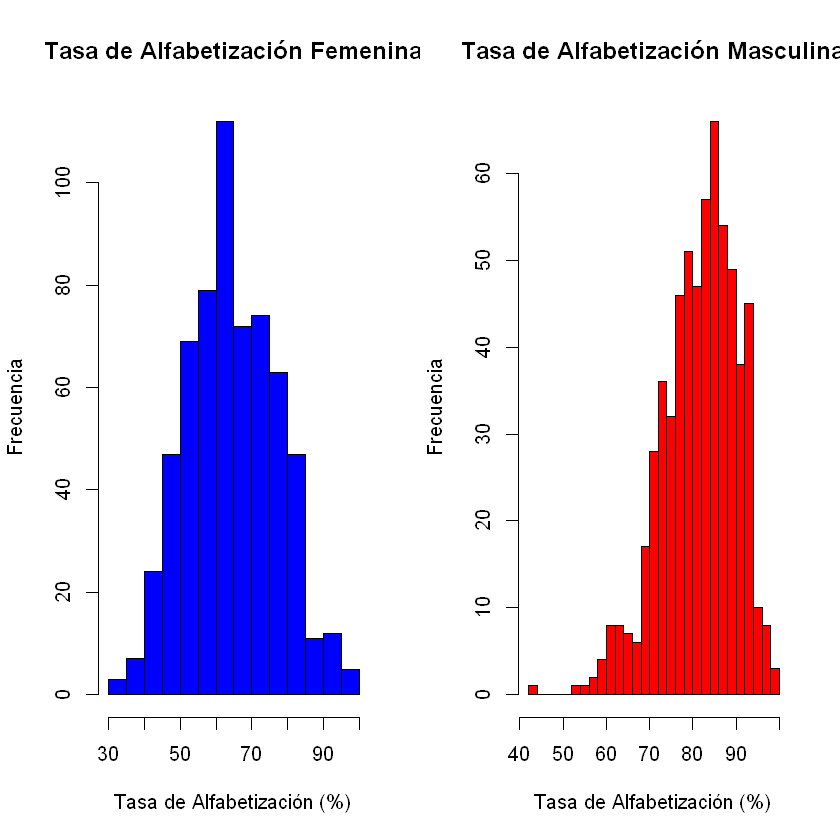

In [ ]:
# Tarea 2: Crear histogramas y comentar (1 punto)
par(mfrow = c(1, 2)) # Prepara el área de ploteo para mostrar 2 gráficos
hist(data$FEMALE_LIT, 
     main = "Tasa de Alfabetización Femenina", 
     xlab = "Tasa de Alfabetización (%)", 
     ylab = "Frecuencia", 
     col = "blue", 
     breaks = 20)
hist(data$MALE_LIT, 
     main = "Tasa de Alfabetización Masculina", 
     xlab = "Tasa de Alfabetización (%)", 
     ylab = "Frecuencia", 
     col = "red", 
     breaks = 20)
par(mfrow = c(1, 1)) # Restaura el área de ploteo a un solo gráfico





En promedio, la tasa de alfabetización masculina es mayor que la femenina. 
Ambas distribuciones están sesgadas hacia la izquierda (la mayoría de los distritos tienen tasas de alfabetización altas), pero el sesgo es más pronunciado en los hombres, indicando que valores muy altos son más comunes en hombres que en mujeres.

In [4]:
# 3. Preparación para los modelos
# Seleccionar variables relevantes para el modelo de baja dimensión.
# Puedes añadir o quitar las que consideres.
data_low_dim <- select(data, STATCD, DISTCD, TOTPOPULAT, P_URB_POP, POPULATION_0_6,
                 GROWTHRATE, SEXRATIO, P_SC_POP, P_ST_POP, AREA_SQKM, TOT_6_10_15,
                 TOT_11_13_15, SCHTOT, SCHTOTG, SCHTOTP, SCHTOTGR)

# Definir la matriz de predictores (X) y la variable respuesta (y)
X_low <- as.matrix(data_low_dim)
y <- data$FEMALE_LIT

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
set.seed(1234) # Para reproducibilidad
train_idx <- sample(1:nrow(data), 0.8 * nrow(data))

X_train_low <- X_low[train_idx, ]
X_test_low <- X_low[-train_idx, ]
y_train <- y[train_idx]
y_test <- y[-train_idx]

# Tarea 3: Estimar modelo de baja dimensión y calcular R^2 (2 puntos)
lasso_low <- cv.glmnet(X_train_low, y_train, alpha = 1)
y_pred_low <- predict(lasso_low, newx = X_test_low, s = "lambda.min")
r2_low <- 1 - sum((y_test - y_pred_low)^2) / sum((y_test - mean(y_test))^2)
cat("R^2 para el modelo de baja dimensión:", r2_low, "\n")



R^2 para el modelo de baja dimensión: 0.4609164 


In [5]:
# Tarea 4: Estimar modelo de alta dimensión (flexible) y calcular R^2 (2 puntos)
# Crear interacciones y términos cuadráticos a partir de las variables de baja dimensión
X_high <- model.matrix(~ .^2 + I(TOTPOPULAT^2) + I(P_URB_POP^2) + 
                       I(POPULATION_0_6^2), data = as.data.frame(X_low))[,-1]

# Dividir el nuevo set de datos flexible
X_train_high <- X_high[train_idx, ]
X_test_high <- X_high[-train_idx, ]

# Entrenar y evaluar el modelo de alta dimensión
lasso_high <- cv.glmnet(X_train_high, y_train, alpha = 1)
y_pred_high <- predict(lasso_high, newx = X_test_high, s = "lambda.min")
r2_high <- 1 - sum((y_test - y_pred_high)^2) / sum((y_test - mean(y_test))^2)
cat("R^2 para el modelo de alta dimensión:", r2_high, "\n")




R^2 para el modelo de alta dimensión: 0.6447344 


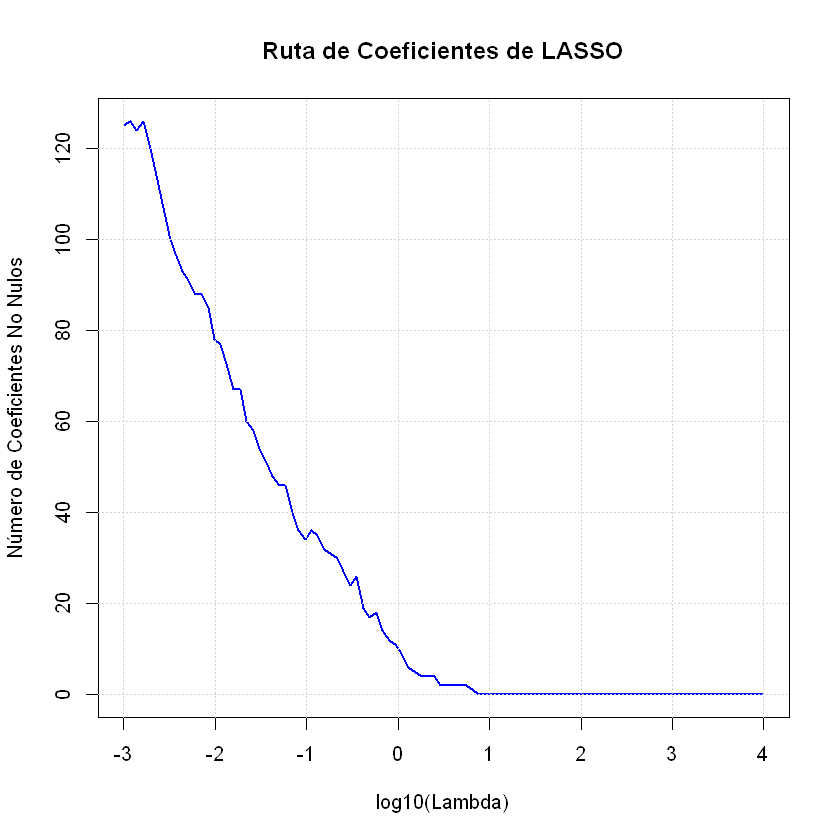

In [ ]:
# Tarea 5: Graficar la ruta de coeficientes (2.75 puntos)
lambda_seq <- 10^seq(4, -3, length = 100) # Rango de lambda de 10,000 a 0.001
lasso_path <- glmnet(X_train_high, y_train, alpha = 1, lambda = lambda_seq)

# Contar coeficientes no nulos para cada lambda (excluyendo el intercepto)
nonzero_coefs <- apply(coef(lasso_path), 2, function(x) sum(x != 0) - 1)

# Graficar
plot(log10(lambda_seq), nonzero_coefs, type = "l", col = "blue", lwd = 2,
     xlab = "log10(Lambda)", ylab = "Número de Coeficientes No Nulos",
     main = "Ruta de Coeficientes de LASSO")
grid()



El gráfico muestra cómo el número de variables (coeficientes no nulos) que el modelo considera importantes disminuye a medida que aumenta el parámetro de penalización lambda. Con un lambda muy grande (a la izquierda), el modelo es muy simple y selecciona pocas o ninguna variable. A medida que lambda disminuye (hacia la derecha), el modelo se vuelve más complejo, incluyendo más variables. Esto ilustra la capacidad de LASSO para realizar selección de variables.